# Census income classification with scikit-learn

This example uses the standard <a href="https://archive.ics.uci.edu/ml/datasets/Adult">adult census income dataset</a> from the UCI machine learning data repository. We first process the data so the columns of each categorical variable are grouped together. Then train a random forest classifer and explain its predictions using Shap.

In [1]:
import numpy as np
import shap

shap.initjs()

In [2]:
import random
random.seed(0)

## Load and process the census data

In [3]:
# load the data
raw_train_data = np.genfromtxt("data/adult.data", delimiter=",", dtype=None, autostrip=True, deletechars=["'"])
raw_test_data = np.genfromtxt("data/adult.test", delimiter=",", dtype=None, autostrip=True, deletechars=["'"], skip_header=1)

# extract the category options in the training data
col_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex", "capital-gain",
    "capital-loss", "hours-per-week", "native-country"
]
work_classes = list(set([v[col_names.index("workclass")] for v in raw_train_data]))
education_types = list(set([v[col_names.index("education")] for v in raw_train_data]))
marriage_statuses = list(set([v[col_names.index("marital-status")] for v in raw_train_data]))
occupations = list(set([v[col_names.index("occupation")] for v in raw_train_data]))
relationships = list(set([v[col_names.index("relationship")] for v in raw_train_data]))
races = list(set([v[col_names.index("race")] for v in raw_train_data]))
sexes = list(set([v[col_names.index("sex")] for v in raw_train_data]))
countries = list(set([v[col_names.index("native-country")] for v in raw_train_data]))
types = [work_classes, education_types, marriage_statuses, occupations, relationships, races, sexes, countries]
N = raw_train_data.shape[0]
P = sum(map(len, types)) + 5

def build_matrix(data, P):
    N = data.shape[0]
    X = np.zeros((N, P))
    
    group_names = []
    feature_groups = []
    
    
    def assign_class(i, offset, name, classes, data_col):
        if i == 0:
            group_names.append(name)
            feature_groups.append(list(range(offset, offset+len(classes))))
        j = classes.index(data[i][data_col])
        X[i,offset+j] = 1
        offset += len(classes)
        return offset
    
    def assign_num(i, offset, name, data_col):
        if i == 0:
            group_names.append(name)
            feature_groups.append([offset])
        X[i,offset] = data[i][data_col]
        offset += 1
        return offset
    
    for i in range(N):
        offset = 0
        offset = assign_num(i, offset, "Age", 0)
        offset = assign_class(i, offset, "Work class", work_classes, 1)
        offset = assign_class(i, offset, "Education", education_types, 3)
        offset = assign_num(i, offset, "Years in school", 4)
        offset = assign_class(i, offset, "Marital status", marriage_statuses, 5)
        offset = assign_class(i, offset, "Occupation", occupations, 6)
        offset = assign_class(i, offset, "Relationship", relationships, 7)
        offset = assign_class(i, offset, "Race", races, 8)
        offset = assign_class(i, offset, "Sex", sexes, 9)
        offset = assign_num(i, offset, "Capital gain", 10)
        offset = assign_num(i, offset, "Capital loss", 11)
        offset = assign_num(i, offset, "Weekly working hours", 12)
        offset = assign_class(i, offset, "Native country", countries, 13)
        
    y = np.array(list(v[-1] == b'>50K' for v in data))
    
    return X,y,group_names,feature_groups

def group_values(x):
    out = []
    offset = 0
    
    def add_class(offset, class_members):
        pos = -1
        try:
            pos = list(x[offset:offset+len(class_members)]).index(1)
        except:
            pass
        out.append("" if pos == -1 else class_members[pos])
        offset += len(class_members)
        return offset
    
    out.append(x[0])
    offset += 1
    offset = add_class(offset, work_classes)
    offset = add_class(offset, education_types)
    out.append(x[offset])
    offset += 1
    offset = add_class(offset, marriage_statuses)
    offset = add_class(offset, occupations)
    offset = add_class(offset, relationships)
    offset = add_class(offset, races)
    offset = add_class(offset, sexes)
    out.append(x[offset])
    offset += 1
    out.append(x[offset])
    offset += 1
    out.append(x[offset])
    offset += 1
    offset = add_class(offset, countries)
    
    return out

# build the training data
train_data,train_labels,group_names,feature_groups = build_matrix(raw_train_data, P)
data_median = shap.DenseData(np.reshape(np.median(train_data,0), (1,train_data.shape[1])), group_names, feature_groups)

# and test data
test_data,test_labels,group_names,feature_groups = build_matrix(raw_test_data, P)

## Train a random forest classifier

Note that we set min_samples_leaf = 100 because otherwise the classifier might predict samples with 100% certainty. This is a problem if we want to use a logistic link below since a probability of exactly $1$ corresponds to an infinite logistic link value.

In [3]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=100, random_state=0)
rforest.fit(train_data, train_labels);

In [39]:
group_names

['Age',
 'Work class',
 'Education',
 'Years in school',
 'Marital status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital gain',
 'Capital loss',
 'Weekly working hours',
 'Native country']

In [40]:
feature_groups[5]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]

In [61]:
tmp2 = train_data[0:1,:]

In [62]:
model.predict(xgb.DMatrix(tmp2))

array([ 0.12765355], dtype=float32)

In [68]:
tmp2[:,feature_groups[5][11]] = 0
tmp2[:,feature_groups[5][7]] = 1
model.predict(xgb.DMatrix(tmp2))

array([ 0.12765355], dtype=float32)

In [10]:
marriage_statuses

[b'Separated',
 b'Never-married',
 b'Married-AF-spouse',
 b'Divorced',
 b'Widowed',
 b'Married-civ-spouse',
 b'Married-spouse-absent']

In [80]:
for i in range(len(feature_groups[4])):
    tmp2[:,feature_groups[4]] = 0
    tmp2[:,feature_groups[4][i]] = 1
    print(tmp2[:,feature_groups[4]])
    print(i, model.predict(xgb.DMatrix(tmp2)))

[[ 1.  0.  0.  0.  0.  0.  0.]]
0 [ 0.12765355]
[[ 0.  1.  0.  0.  0.  0.  0.]]
1 [ 0.12765355]
[[ 0.  0.  1.  0.  0.  0.  0.]]
2 [ 0.12765355]
[[ 0.  0.  0.  1.  0.  0.  0.]]
3 [ 0.12751076]
[[ 0.  0.  0.  0.  1.  0.  0.]]
4 [ 0.12765355]
[[ 0.  0.  0.  0.  0.  1.  0.]]
5 [ 0.12765355]
[[ 0.  0.  0.  0.  0.  0.  1.]]
6 [ 0.57527345]


In [69]:
tmp2[:,feature_groups[5]]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]])

In [9]:
feature_groups[4]


[27, 28, 29, 30, 31, 32, 33]

In [8]:
for i in range(train_data.shape[1]):
    print(i, np.mean(train_labels[np.nonzero(train_data[:,i])[0]]) - np.mean(train_labels[np.nonzero(train_data[:,i]-1)[0]]))

0 0.0
1 -0.144952411848
2 0.0324404955089
3 0.0576909434043
4 -0.240913140996
5 -0.240861338084
6 -0.073065575434
7 0.150073408806
8 0.327772221054
9 0.0478519108735
10 -0.120001807884
11 -0.0651671263209
12 0.208180488005
13 -0.179500648685
14 -0.166815417315
15 0.0213105652163
16 0.333421124159
17 -0.182511013921
18 -0.194753242755
19 -0.196849252479
20 -0.206158958505
21 0.506535376185
22 -0.241187326976
23 0.00780613126411
24 -0.191300192725
25 0.502453786931
26 -0.000377769530291
27 -0.182153388771
28 -0.289993053905
29 0.194110164169
30 -0.158185328007
31 -0.160092645477
32 0.381508512378
33 -0.161543652044
34 -0.145404273916
35 0.0321043182597
36 0.277907438305
37 -0.129734305453
38 -0.12352960041
39 0.0660291944685
40 -0.0425192703636
41 -0.129055098481
42 -0.0162094718845
43 0.0860205511227
44 -0.120249623026
45 -0.221662471805
46 0.238555648873
47 -0.185855689703
48 -0.235174311942
49 -0.269542679889
50 -0.184899547313
51 0.349283727496
52 -0.198562049407
53 -0.209401813687
5

In [101]:
np.mean(train_labels[np.nonzero(train_data[:,33]-1)[0]])

0.26240352811466372

In [84]:
train_data[0:15, feature_groups[4]]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.]])

In [4]:
np.mean(train_labels)

0.24080955744602439

In [7]:
train_data[:,32]

array([ 0.,  1.,  0., ...,  0.,  0.,  1.])

In [6]:
bst.get_score(importance_type="gain")

{'f0': 36.627278884615386,
 'f16': 17.4252,
 'f26': 336.5233626764706,
 'f32': 2258.125,
 'f35': 4.1239799999999995,
 'f36': 14.5791,
 'f62': 343.46759999999995,
 'f63': 74.8918122857143,
 'f64': 33.451922399999994}

In [ ]:
shap.explain(bst, module_expression_test, feature_names=[str(i) for i in range(module_expression_test.shape[1])])

In [4]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_data, label=train_labels)
dtest = xgb.DMatrix(test_data, label=test_labels)

param = {'max_depth':5, 'eta':0.005, 'silent':1, 'objective':'binary:logistic' }
#param['nthread'] = 4
param['min_child_weight'] = 10
param['base_rate'] = np.mean(train_labels)
param['eval_metric'] = 'logloss'
param['subsample'] = 0.5

evallist  = [(dtest,'eval'), (dtrain,'train')]
bst = xgb.train(param.items(), dtrain, 500, evallist ) # 500

[0]	eval-logloss:0.690528	train-logloss:0.690273
[1]	eval-logloss:0.687928	train-logloss:0.687439
[2]	eval-logloss:0.685342	train-logloss:0.684602
[3]	eval-logloss:0.682778	train-logloss:0.681805
[4]	eval-logloss:0.680264	train-logloss:0.679048
[5]	eval-logloss:0.677751	train-logloss:0.676307
[6]	eval-logloss:0.675304	train-logloss:0.673619
[7]	eval-logloss:0.672892	train-logloss:0.670936
[8]	eval-logloss:0.670451	train-logloss:0.668262
[9]	eval-logloss:0.668058	train-logloss:0.665627
[10]	eval-logloss:0.665686	train-logloss:0.663029
[11]	eval-logloss:0.663322	train-logloss:0.660442
[12]	eval-logloss:0.661004	train-logloss:0.657853
[13]	eval-logloss:0.658711	train-logloss:0.655293
[14]	eval-logloss:0.656437	train-logloss:0.6528
[15]	eval-logloss:0.654189	train-logloss:0.650315
[16]	eval-logloss:0.651951	train-logloss:0.647854
[17]	eval-logloss:0.649749	train-logloss:0.645389
[18]	eval-logloss:0.647548	train-logloss:0.642946
[19]	eval-logloss:0.645354	train-logloss:0.640545
[20]	eval-lo

In [5]:
def explain_bst(out, data, feature_names):
    if out.shape[0] == 1:
        instance = iml.Instance(data[0:1,:], data[0,:])
        e = iml.AdditiveExplanation(out[0,-1], np.sum(out[0,:]), out[0,:-1], None, instance, iml.IdentityLink(), iml.Model(None, ["out value"]), iml.DenseData(np.zeros((1,data.shape[1])), feature_names))
        return e
    else:
        exps = []
        for i in range(out.shape[0]):
            instance = iml.Instance(data[i:i+1,:], data[i,:])
            e = iml.AdditiveExplanation(out[i,-1], np.sum(out[i,:]), out[i,:-1], None, instance, iml.IdentityLink(), iml.Model(None, ["out value"]), iml.DenseData(np.zeros((1,data.shape[1])), feature_names))
            exps.append(e)
        return exps

## Explain one test prediction using a Logit link

By using a logit link function for our explanation we allow the additive feature inputs to better map to the model's probabilistic output space.

In [6]:
f(data_median.data)

NameError: name 'f' is not defined

In [69]:
explaination.__dict__

{'base_value': 0.071201056,
 'data': <iml.datatypes.DenseData at 0x10dcbb278>,
 'effects': array([ 0.00972435,  0.        ,  0.02188335, -0.20647848,  1.73804202,
        -0.12185152,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.31162505,  0.        ]),
 'effects_var': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.]),
 'instance': <iml.common.Instance at 0x11f030ac8>,
 'link': <iml.links.LogitLink at 0x11f030b70>,
 'model': <iml.common.Model at 0x11f030ba8>,
 'out_value': 0.30673251}

In [20]:
np.mean(f(train_data[i:i+100,:]))

0.29786766

In [28]:
np.random.permutation(train_data.shape[0])[0:100]

(100,)

In [23]:
np.shuffle(collect(range(train_data.shape[0])))

AttributeError: module 'numpy' has no attribute 'shuffle'

In [43]:
np.mean(f(train_data))

0.26220024

In [5]:
data_background = shap.DenseData(train_data[np.random.permutation(train_data.shape[0])[0:100],:], group_names, feature_groups)
#np.mean(f(data_background.data))

In [58]:
i = 1
f = lambda x: bst.predict(xgb.DMatrix(x))
explainer = shap.KernelExplainer(f, data_background, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[i:i+1,:], group_values(test_data[i:i+1,:][0])))
shap.visualize(explaination)

In [6]:
i = 2
f = lambda x: bst.predict(xgb.DMatrix(x))
explainer = shap.KernelExplainer(f, data_background, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[i:i+1,:], tmp))
shap.visualize(explaination)

NameError: name 'tmp' is not defined

In [26]:
i = 2
f = lambda x: bst.predict(xgb.DMatrix(x))
explainer = shap.KernelExplainer(f, data_background, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[i:i+1,:], tmp))
shap.visualize(explaination)

NameError: name 'tmp' is not defined

In [18]:
fscores = model.get_fscore()
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0
    for i in g:
        total += fscores.get("f"+str(i), 0)
    group_vals[ind] = total
group_vals

array([ 2257.,   238.,   196.,  1434.,   599.,   764.,   216.,     6.,
         218.,  1336.,   798.,  1399.,    15.])

In [8]:
from matplotlib import pyplot as plt
import seaborn

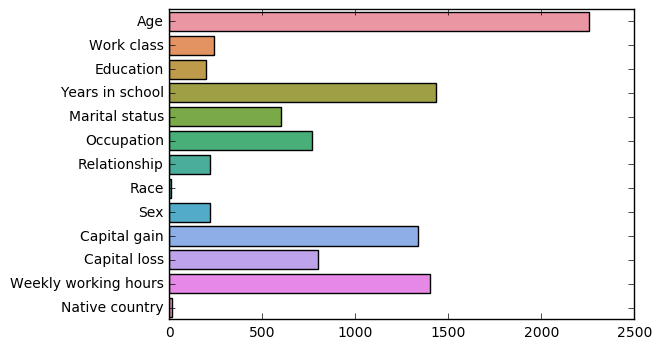

In [9]:
fscores = bst.get_fscore()
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0
    for i in g:
        total += fscores.get("f"+str(i), 0)
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.show()

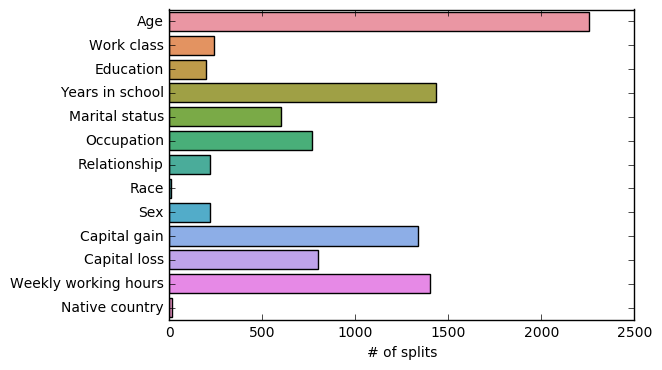

In [17]:
fscores = bst.get_score(importance_type="weight")
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0
    for i in g:
        total += fscores.get("f"+str(i), 0)
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("# of splits")
plt.show()

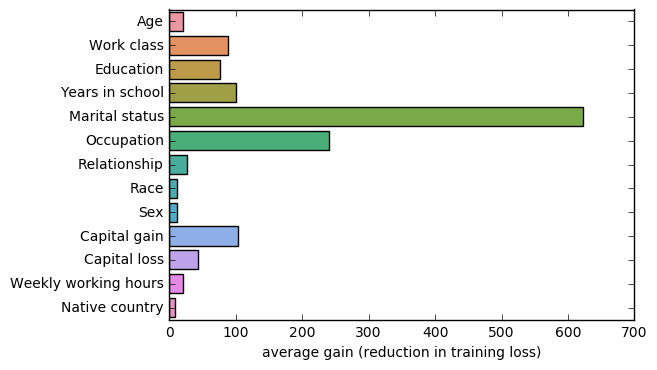

In [18]:
fscores = bst.get_score(importance_type="gain")
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0
    for i in g:
        total += fscores.get("f"+str(i), 0)
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("average gain (reduction in training loss)")
plt.show()

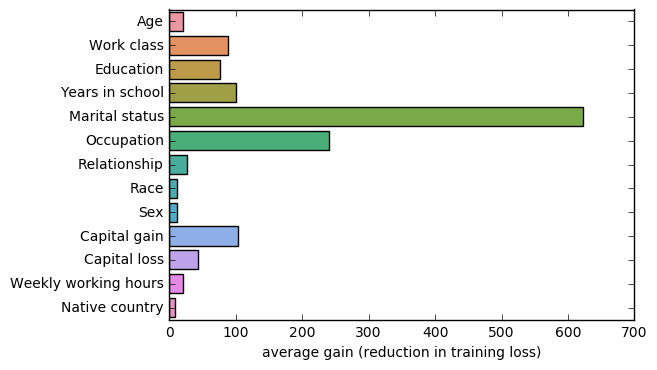

In [19]:
fscores = bst.get_score(importance_type="gain")
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0
    for i in g:
        total += fscores.get("f"+str(i), 0)
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("average gain (reduction in training loss)")
plt.show()

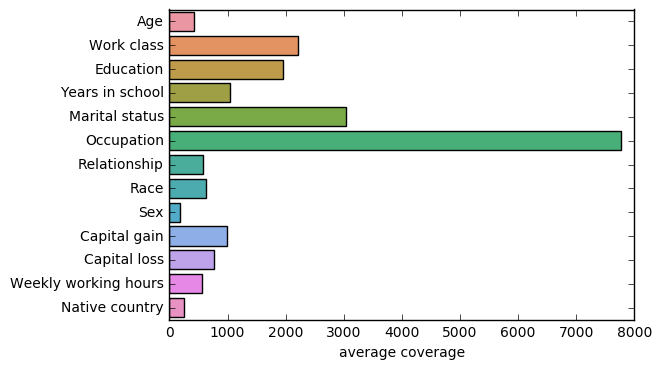

In [20]:
fscores = bst.get_score(importance_type="cover")
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0
    for i in g:
        total += fscores.get("f"+str(i), 0)
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("average coverage")
plt.show()

In [21]:
fscores = list(model.predict(xgb.DMatrix(test_data[i:i+1,:]), pred_contribs=True)[0,:-1])
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0
    for i in g:
        total += fscores[i]
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("average coverage")
plt.show()

NameError: name 'model' is not defined

In [18]:
test_data[i:i+1,:][0,38]

0.0

In [15]:
group_names

['Age',
 'Work class',
 'Education',
 'Years in school',
 'Marital status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital gain',
 'Capital loss',
 'Weekly working hours',
 'Native country']

In [16]:
feature_groups[5]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]

In [30]:
a = test_data[i:i+1,:]

In [32]:
a[0,38]

0.0

In [48]:
fscores[feature_groups[5]]

array([ 0.        , -0.02374627,  0.        ,  0.        , -0.00090231,
       -0.00077091,  0.00215814,  0.        ,  0.        ,  0.00345634,
       -0.00025195, -0.00015101,  0.        , -0.00385765,  0.        ], dtype=float32)

In [10]:
feature_groups[8]

[60, 61]

In [14]:
tmp2 = test_data[i:i+1,:]
tmp2[0,60:62]
tmp2[60] = 1
tmp2 = 61 = 0

SyntaxError: can't assign to literal (<ipython-input-14-e838fee382a6>, line 4)

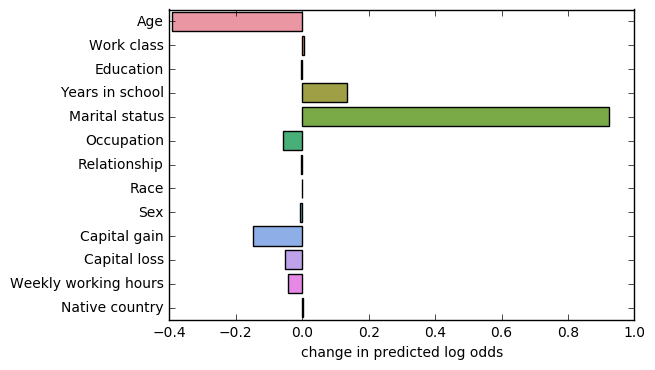

In [20]:
i = 2
tmp2 = test_data[i:i+1,:]
tmp2[0,60:62]
tmp2[0,60] = 1
tmp2[0,61] = 0
fscores = bst.predict(xgb.DMatrix(tmp2), pred_contribs=True)[0,:-1]
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0.0
    for i in g:
        total += fscores[i]
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("change in predicted log odds")
plt.show()

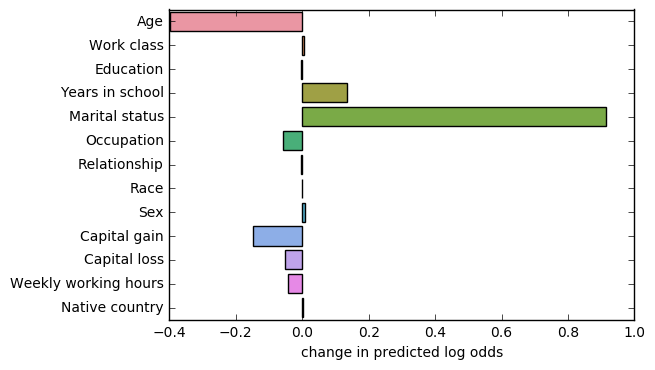

In [8]:
i = 2
fscores = bst.predict(xgb.DMatrix(test_data[i:i+1,:]), pred_contribs=True)[0,:-1]
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0.0
    for i in g:
        total += fscores[i]
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("change in predicted log odds")
plt.show()

In [20]:
fscores = bst.predict(xgb.DMatrix(test_data[0:1000,:]), pred_contribs=True)

In [39]:
feature_groups[9]

[62]

In [15]:
group_names

['Age',
 'Work class',
 'Education',
 'Years in school',
 'Marital status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital gain',
 'Capital loss',
 'Weekly working hours',
 'Native country']

In [21]:
fscores.shape

(1000, 108)

In [18]:
fscores[:1000,0]

IndexError: too many indices for array

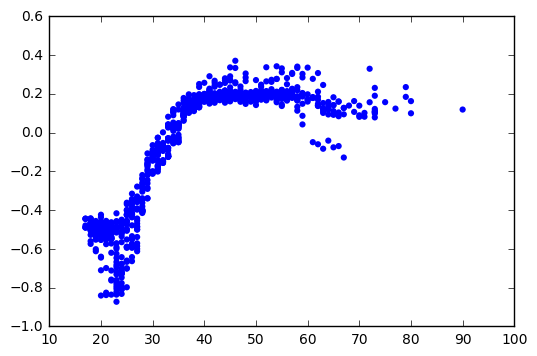

In [24]:
plt.scatter(test_data[:1000,0], fscores[:1000,0], edgecolors="none")
plt.show()

In [29]:
a = list(range(test_data.shape[0]))
np.random.shuffle(a)
a

[7483,
 5946,
 3781,
 1311,
 15171,
 13656,
 10172,
 6138,
 13567,
 7635,
 13190,
 3711,
 6664,
 14915,
 4234,
 5717,
 6260,
 5096,
 2982,
 12847,
 4485,
 15122,
 8715,
 6782,
 10100,
 5314,
 9663,
 10014,
 8216,
 1550,
 7285,
 11709,
 3265,
 9783,
 2819,
 3842,
 492,
 6328,
 7478,
 12638,
 1239,
 7494,
 303,
 10813,
 10269,
 9380,
 5641,
 1809,
 11909,
 9573,
 14906,
 10853,
 52,
 5491,
 14548,
 777,
 16042,
 9112,
 5184,
 11521,
 13480,
 6154,
 4548,
 1714,
 5142,
 1020,
 7834,
 1072,
 318,
 13219,
 10695,
 6879,
 1427,
 841,
 10188,
 8787,
 12038,
 930,
 654,
 8648,
 7464,
 5022,
 6541,
 11398,
 12445,
 1712,
 4097,
 15045,
 8377,
 4878,
 1367,
 13630,
 7083,
 959,
 691,
 7099,
 10545,
 537,
 14122,
 1141,
 8480,
 11767,
 14498,
 165,
 8058,
 743,
 3380,
 3921,
 2937,
 8776,
 5644,
 2101,
 4474,
 4061,
 9785,
 14646,
 7025,
 13936,
 1033,
 5577,
 3536,
 8773,
 3420,
 12151,
 6398,
 5904,
 566,
 6823,
 10193,
 5728,
 7872,
 12255,
 13323,
 151,
 3222,
 13188,
 3494,
 13538,
 1215,
 2934,
 1849,
 11059,
 14940,
 16271,
 732,
 8740,
 11769,
 3438,
 4257,
 3178,
 5738,
 6275,
 11373,
 16060,
 10526,
 11118,
 6233,
 13409,
 9786,
 6811,
 417,
 9838,
 2686,
 14150,
 3759,
 4585,
 14830,
 12603,
 13010,
 11601,
 1545,
 8763,
 2855,
 15771,
 10446,
 2566,
 7307,
 12566,
 5275,
 5850,
 15250,
 7167,
 14694,
 3901,
 12338,
 7048,
 6415,
 8735,
 12971,
 16112,
 1424,
 3286,
 1668,
 12782,
 4883,
 3940,
 9361,
 1642,
 9503,
 7901,
 15061,
 13259,
 2814,
 1110,
 6000,
 12465,
 150,
 1378,
 8144,
 5354,
 1293,
 9233,
 10073,
 2206,
 1991,
 16185,
 483,
 4332,
 14502,
 16093,
 2771,
 15750,
 7428,
 10929,
 5405,
 3064,
 5500,
 7972,
 2918,
 14239,
 16040,
 11171,
 13195,
 6205,
 14491,
 4541,
 8071,
 2233,
 2346,
 6402,
 1338,
 2341,
 7905,
 12341,
 7208,
 3167,
 10673,
 6496,
 6535,
 9513,
 9212,
 10907,
 820,
 2064,
 11248,
 13349,
 9433,
 15282,
 14295,
 7841,
 11985,
 8910,
 6194,
 2792,
 11155,
 7190,
 9092,
 5322,
 10728,
 8013,
 13194,
 12429,
 42,
 9001,
 5576,
 7059,
 2662,
 8193,
 6934,
 13946,
 13384,
 14398,
 891,
 1555,
 15074,
 16187,
 15309,
 11049,
 13486,
 686,
 149,
 16011,
 2689,
 15686,
 2711,
 11931,
 10764,
 1064,
 8029,
 5961,
 597,
 7514,
 5650,
 12524,
 6850,
 6737,
 4731,
 12990,
 14768,
 192,
 12156,
 1219,
 9717,
 10688,
 5890,
 6964,
 11844,
 12279,
 4399,
 515,
 11499,
 14024,
 2808,
 7267,
 11084,
 12510,
 839,
 14649,
 12642,
 1211,
 15988,
 13082,
 12454,
 3590,
 922,
 14231,
 10633,
 12269,
 10732,
 9658,
 3922,
 13207,
 6210,
 5011,
 670,
 2093,
 15406,
 2579,
 6189,
 973,
 13488,
 16006,
 3190,
 15102,
 3205,
 14536,
 5428,
 6948,
 12093,
 5617,
 2773,
 3272,
 15010,
 8014,
 15469,
 13622,
 6624,
 14718,
 4410,
 10920,
 5907,
 5671,
 13672,
 13687,
 10227,
 5542,
 15073,
 9591,
 11699,
 13503,
 14448,
 6572,
 377,
 15354,
 160,
 7200,
 4278,
 4544,
 1769,
 5924,
 12718,
 4187,
 1827,
 6565,
 10578,
 12103,
 4408,
 6253,
 13668,
 15427,
 7102,
 7503,
 12857,
 13187,
 15486,
 3998,
 8649,
 12224,
 9085,
 9561,
 10208,
 10582,
 15979,
 2469,
 14824,
 3954,
 4523,
 6841,
 15390,
 13435,
 9166,
 5983,
 9204,
 11154,
 15193,
 9058,
 9556,
 12451,
 12073,
 2072,
 2096,
 13388,
 7760,
 12814,
 8176,
 5689,
 1736,
 3223,
 13069,
 1781,
 9028,
 14640,
 12303,
 3108,
 12292,
 2563,
 16120,
 15433,
 16013,
 15730,
 7405,
 11679,
 8078,
 16275,
 12138,
 1814,
 3984,
 4744,
 563,
 13666,
 13616,
 13352,
 13452,
 12499,
 855,
 13920,
 3582,
 12344,
 9885,
 10586,
 9740,
 7987,
 10397,
 2173,
 3627,
 398,
 11859,
 7345,
 16230,
 5597,
 10300,
 13164,
 5343,
 5144,
 6281,
 10643,
 13505,
 9806,
 16022,
 6280,
 1058,
 15340,
 16132,
 11753,
 14431,
 1824,
 10444,
 5238,
 12325,
 9926,
 7492,
 15392,
 3426,
 13491,
 11948,
 10477,
 1468,
 6360,
 1117,
 460,
 14321,
 4417,
 7071,
 7229,
 15781,
 11197,
 4386,
 8359,
 6899,
 14040,
 999,
 11434,
 1491,
 2880,
 5318,
 3252,
 2363,
 5160,
 4576,
 13677,
 16250,
 4739,
 10215,
 14422,
 13575,
 4090,
 4648,
 14949,
 3833,
 10574,
 8620,
 2001,
 5614,
 13967,
 13489,
 11939,
 11

In [37]:
def plot_dep(ind, name, xscale="linear", num_samples=1000):
    rinds = list(range(test_data.shape[0]))
    np.random.shuffle(rinds)
    fscores = bst.predict(xgb.DMatrix(test_data[rinds[:num_samples],:]), pred_contribs=True)
    plt.scatter(test_data[rinds[:num_samples],ind], fscores[:,ind], marker='.', alpha=1, s=15, linewidth='0')
    plt.gca().set_xscale(xscale)
    plt.gca().set_axis_bgcolor("white")
    #plt.gca().grid(color="lightgray", linestyle="--", linewidth=0.3)
    plt.xlabel(name)
    plt.ylabel(name+" SHAP value")
    plt.show()

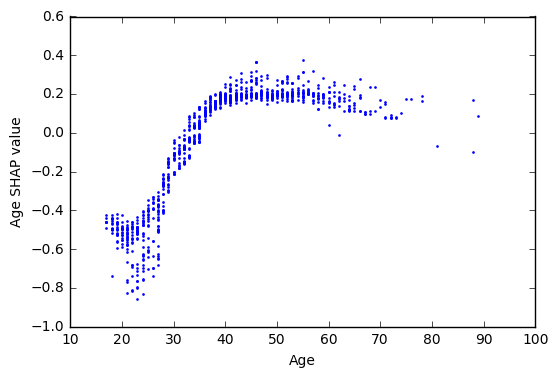

In [38]:
plot_dep(0, "Age")

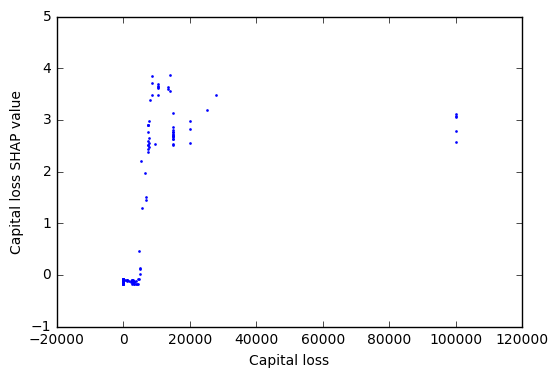

In [43]:
plot_dep(62, "Capital loss")

In [48]:
group_preds = pd.DataFrame(fscores, columns=group_names)
seaborn.clustermap(fscores.transpose())
plt.show()

NameError: name 'pd' is not defined

In [14]:
test_data.shape

(16281, 107)

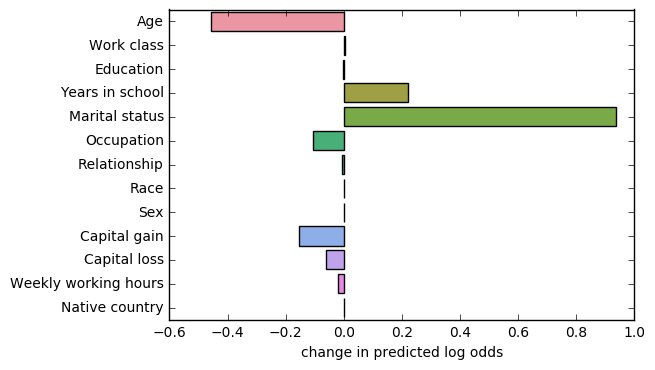

In [30]:
i = 2
fscores = bst.predict(xgb.DMatrix(test_data[i:i+1,:]), pred_contribs=True)[0,:-1]
group_vals = np.zeros(len(feature_groups))
for (ind,g) in enumerate(feature_groups):
    total = 0.0
    for i in g:
        total += fscores[i]
    group_vals[ind] = total
group_vals

seaborn.barplot(group_vals, group_names, orient="h")
plt.xlabel("change in predicted log odds")
plt.show()

In [49]:
#model.save_model("pres_model.xgb_model")

In [6]:
model = bst
model.load_model("pres_model.xgb_model")

In [13]:
model.get_fscore()
# plotting/grouping code...

{'f0': 2257,
 'f1': 1,
 'f100': 15,
 'f11': 3,
 'f12': 27,
 'f17': 58,
 'f18': 3,
 'f19': 36,
 'f2': 1,
 'f20': 2,
 'f21': 2,
 'f23': 42,
 'f25': 23,
 'f26': 1434,
 'f29': 7,
 'f3': 59,
 'f30': 67,
 'f33': 525,
 'f34': 8,
 'f35': 359,
 'f36': 1,
 'f37': 19,
 'f38': 23,
 'f39': 7,
 'f4': 9,
 'f40': 65,
 'f43': 63,
 'f44': 5,
 'f45': 14,
 'f46': 1,
 'f47': 196,
 'f48': 3,
 'f49': 2,
 'f5': 145,
 'f50': 44,
 'f51': 132,
 'f53': 29,
 'f54': 9,
 'f55': 5,
 'f56': 1,
 'f60': 218,
 'f62': 1336,
 'f63': 798,
 'f64': 1399,
 'f8': 20,
 'f9': 3}

In [10]:
i = 2
f = lambda x: bst.predict(xgb.DMatrix(x))
explainer = shap.KernelExplainer(f, data_background, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[i:i+1,:], tmp))
shap.visualize(explaination)

In [24]:
group_values(test_data[i:i+1,:][0])

[28.0,
 b'Local-gov',
 b'Assoc-acdm',
 12.0,
 b'Married-civ-spouse',
 b'Protective-serv',
 b'Husband',
 b'White',
 b'Male',
 0.0,
 0.0,
 40.0,
 b'United-States']

In [28]:
i = 2
f = lambda x: bst.predict(xgb.DMatrix(x))
explainer = shap.KernelExplainer(f, data_background, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[i:i+1,:], group_values(test_data[i:i+1,:][0])))
shap.visualize(explaination)

In [67]:
explaination.effects

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.53535947,
       -0.04658039,  0.        ,  0.        ,  0.        , -0.15437172,
       -0.0380755 , -0.07563282,  0.        ])

In [22]:
tmp = group_values(test_data[i:i+1,:][0])
tmp[9] = "0"
tmp

[28.0,
 b'Local-gov',
 b'Assoc-acdm',
 12.0,
 b'Married-civ-spouse',
 b'Protective-serv',
 b'Husband',
 b'White',
 b'Male',
 '0',
 0.0,
 40.0,
 b'United-States']

In [15]:
i = 24
f = lambda x: bst.predict(xgb.DMatrix(x))
explainer = shap.KernelExplainer(f, data_median, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[i:i+1,:], group_values(test_data[1:2,:][0])))
shap.visualize(explaination)

In [55]:
explaination.effects

array([-0.10387062,  0.        ,  0.        ,  0.83729566,  1.87319858,
        0.03424393,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.36698977,  0.        ])

In [58]:
explaination.data.__dict__

{'data': array([[ 37.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,  40.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 'group_names': ['Age',
  'Work class',
  'Education',
  'Years in school',
  'Marital status',
  'Occupation',
  'Relationship',
  'Race',
  'Sex',
  'Capital gain',
  'Capital loss',
  'Weekly working hours',
  'Native country'],
 'groups': [[0],
  [1, 2,

In [51]:
f = lambda x: rforest.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, data_median, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[1:2,:], group_values(test_data[1:2,:][0])))
shap.visualize(explaination)

In [60]:
f = lambda x: rforest.predict_proba(x)[:,1]
explainer = shap.KernelExplainer(f, data_median, nsamples=1000, link=shap.LogitLink())
explaination = explainer.explain(shap.Instance(test_data[1:2,:], group_values(test_data[1:2,:][0])))
shap.visualize(explaination)

### Using no link (the identity link)

In [5]:
explainer = shap.KernelExplainer(f, data_median, nsamples=1000)
explaination = explainer.explain(shap.Instance(test_data[1:2,:], group_values(test_data[1:2,:][0])))
shap.visualize(explaination)

In [59]:
explainer = shap.KernelExplainer(f, data_median, nsamples=1000)
explaination = explainer.explain(shap.Instance(test_data[1:2,:], group_values(test_data[1:2,:][0])))
shap.visualize(explaination)

## Explain 100 test predictions using a Logit link

In [69]:
explainer = shap.KernelExplainer(f, data_background, nsamples=1000, link=shap.LogitLink())
exp_arr = []
for i in range(100):
    print(i)
    instance = shap.Instance(test_data[i:i+1,:], group_values(test_data[i:i+1,:][0]))
    exp_arr.append(explainer.explain(instance))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [70]:
shap.visualize(exp_arr)

### Using no link (the identity link)

In [7]:
explainer = shap.KernelExplainer(f, data_median, nsamples=1000)
exp_arr = []
for i in range(100):
    instance = shap.Instance(train_data[i:i+1,:], group_values(train_data[i:i+1,:][0]))
    exp_arr.append(explainer.explain(instance))
shap.visualize(exp_arr)

## Explain one test prediction 10 times to see variability of the Kernel Shap estimator

In [8]:
reps = [explainer.explain(shap.Instance(test_data[2:3,:], group_values(test_data[2:3,:][0]))) for i in range(10)]
shap.visualize(reps)

### Using logit link

In [9]:
explainer = shap.KernelExplainer(f, data_median, nsamples=10, link=shap.LogitLink())
reps = [explainer.explain(shap.Instance(test_data[2:3,:], group_values(test_data[2:3,:][0]))) for i in range(10)]
shap.visualize(reps)